# Simulation Geometric Brownian Motion (GBM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
prices = pd.read_csv('data/prices.csv', index_col=0)
prices = prices.dropna()
prices.index = pd.to_datetime(prices.index, format='%Y%m%d')
prices.index.name = 'date'
prices.head()

,brn,cl,ho,xrb
date,,,,
2015-01-05,49.38,47.57,1.6967,1.3146
2015-01-12,49.91,48.80,1.6573,1.3580
2015-01-19,47.97,44.99,1.6435,1.3333
2015-01-26,52.10,46.88,1.6810,1.4550
2015-02-02,58.60,52.80,1.8420,1.5697


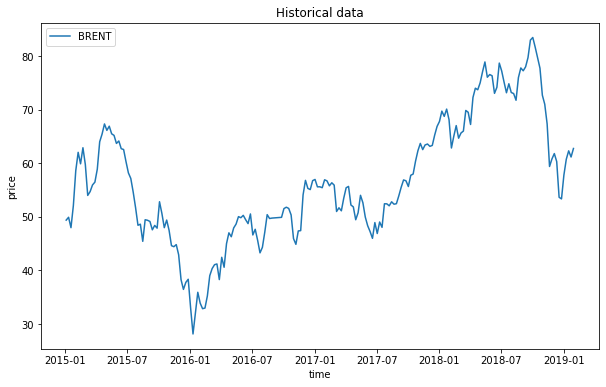

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(prices.brn, label='BRENT')
plt.xlabel('time')
plt.ylabel('price')
plt.title('Historical data')
plt.legend()
plt.show()

# Simulation univariate GBM

## Parameter estimation

In [4]:
returns = (
    (prices.brn.values[1:] - prices.brn.values[:-1]) 
    / prices.brn.values[:-1]
)
returns[:5]

array([ 0.01073309, -0.03886997,  0.08609548,  0.12476008,  0.05853242])

In [5]:
mu = returns.mean()
mu

0.002238735446195556

In [6]:
sigma = returns.std()
sigma

0.04673530468067303

## Simulation

$$X_t = X_0 \exp\left[\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right]$$

drift $ = \left(\mu - \sigma^2/2\right)t$

diffusion $ = \sigma W_t$ where $W_t$ is the Wiener process

In [7]:
dt = 1
T = prices.shape[0]
N = int(T / dt)
x0 = prices.brn.values[0]
ts = np.arange(1, N + 1)
n_sim = 30

In [8]:
np.random.seed(1)
W_values = np.random.normal(size=(N, n_sim))
W_process = W_values.cumsum(axis=0)

In [9]:
drift = np.tile((mu - 0.5 * sigma**2) * ts, (n_sim, 1)).T
diffusion = sigma * np.sqrt(dt) * W_process

In [10]:
X = x0 * np.exp(drift + diffusion)

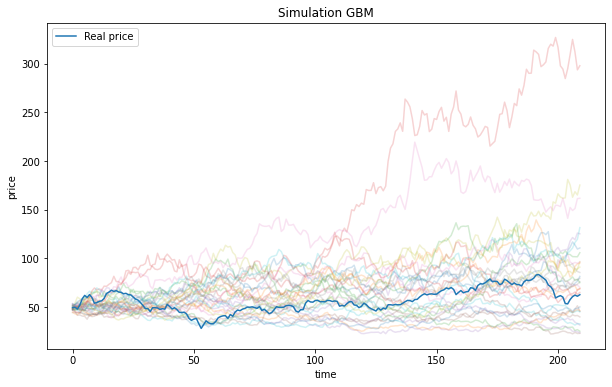

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(X, alpha=0.2)
plt.plot(prices.brn.values, label='Real price')
plt.xlabel('time')
plt.ylabel('price')
plt.title('Simulation GBM')
plt.legend()
plt.show()

# Simulation correlated GBMs

## Parameter estimation

In [12]:
sim_prices = prices[['brn', 'cl']]
returns = (
    (sim_prices.values[1:] - sim_prices.values[:-1])
    / sim_prices.values[:-1]
)
returns[:5]

array([[ 0.01073309,  0.02585663],
       [-0.03886997, -0.07807377],
       [ 0.08609548,  0.04200934],
       [ 0.12476008,  0.12627986],
       [ 0.05853242,  0.01268939]])

In [13]:
mu = returns.mean(axis=0)
mu

array([0.00223874, 0.00182794])

In [14]:
sigma = returns.std(axis=0)
sigma

array([0.0467353 , 0.04740524])

In [15]:
corr = np.corrcoef(sim_prices.T)
corr

array([[1.        , 0.98069769],
       [0.98069769, 1.        ]])

## Simulation

The same approach, but $W_t$ is a correlated vector.


In [16]:
dt = 1
T = prices.shape[0]
N = int(T / dt)
x0 = sim_prices.iloc[0].values
ts = np.arange(1, N + 1)
n_sim = 3
sims = []

In [17]:
np.random.seed(13)
for i in range(n_sim):
    sims.append({})
    W_values = np.random.normal(size=(sim_prices.shape[1], N))
    W_values = (np.linalg.cholesky(corr) @ W_values).T
    W_process = W_values.cumsum(axis=0)
    sims[i]['W_process'] = W_process

In [18]:
for i in range(n_sim):
    drift = (mu - 0.5 * sigma**2) * np.tile(ts, (sim_prices.shape[1], 1)).T
    diffusion = sigma * np.sqrt(dt) * sims[i]['W_process']
    sims[i]['drift'] = drift
    sims[i]['diffusion'] = diffusion

In [19]:
for i in range(n_sim):
    X = x0 * np.exp(sims[i]['drift'] + sims[i]['diffusion'])
    sims[i]['X'] = X

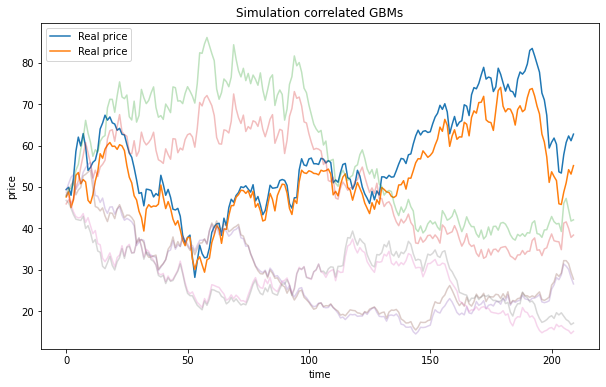

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(sim_prices.values, label='Real price')
for i in range(n_sim):
    plt.plot(sims[i]['X'], alpha = 0.3)
plt.xlabel('time')
plt.ylabel('price')
plt.title('Simulation correlated GBMs')
plt.legend(loc='upper left')
plt.show()